In [1]:
import numpy as np  # Import NumPy library and alias as 'np'
import matplotlib.pyplot as plt # import matplotlib

İmport kodu kütüphaneleri dahil etmek için kullanılır.

Numpy: Pythonda sayısal hesaplamalar yapmak, array ve matris işlemleri yapmak için kullanılır.

Matplotlib: Veri görselleştirme ve grafik oluşturmada kullanılır

In [ ]:
time_step = 0.1  # 0.1 seconds per step
total_time = 200  # 200 seconds
steps = int(total_time / time_step)

Time step 0.1 saniye olarak ayarladık.(Veri tipi float)

Simülasyon toplam süresi 200 saniye olmasını istedik(VT = int veya float olabilir )

Kaç step olucağının hesaplamasını yine intiger veri tipi kullanarak hesapladık.


In [ ]:
battery_capacity_kWh = 50  # Total battery capacity in kWh (dt= int)
regen_efficiency = 0.6  # 60% of braking energy is recovered (dt= float)
#Therotically Regen energy = braking energy x Regen efficiency

rolling_resistance = 0.01  # Coefficient of rolling resistance
air_density = 1.225  # kg/m^3 (for aerodynamic drag) it using to calculate aerodinamic drag calculation
#(0.5 * Cd(drag coefficient) * A (frontal area of car) * v**2 (Velocity))
drag_coefficient = 0.3  # Aerodynamic drag coefficient
frontal_area = 2.5  # m^2
vehicle_mass = 1500  # kg



This parameter will use force calculation in physical model of car

In [ ]:
kp = 0.5  # Proportional gain for ACC control
kd = 0.1  # Derivative gain to reduce noise effects

kp: Kontrol sistemlerinde kullanılan Propotional Controllerı ifade eder. Bu kontrölcü hataya orantılı kontrol girdisi üretir. Bu kontrol girdisi sistemin daha hızlı tepki vermesini sağlar(Setling time düşürür). Verilen bu hızlı tepki momentumu arttırır bu sebeple sistemde overshoot'a neden olur.

Matematiksel Açıklama: Gain değeri yükseldikçe sistem kutupları sağa doğru kayar.

----------------------------------------------
Kd: Kontrol sistemlerinde kullanılan derivative controller (Türev Kontrölcüsü) ifade eder. Bu kontrölcü sşstem değişim hızını kontrol eder ve hızlı değişimleri algılar. Sistemin aşırı tepki vermesini engeller

Dezaantajları : Sistemin hız değişimlerini hesapladığı için, küçük gürültüler bile büyük değişikliklere sebep olabilir.
Sensörlerdeki küçük dalgalanmalar bile, gereksiz büyük düzeltmelere yol açabilir.

Matematiksel açıklama : Transfer fonksiyonuna ekstra zero ekler. Bu zero sistemi stabil hale getirir ancak fazla artırılırsa sistem gürültüye aşırı duyarlı hale gelebilir.

------------------------------------------------

Control Output = Kp* e(t) + kd* (de(t)/dt)

e(t) = velocity error

In [ ]:
ego_speed = np.zeros(steps)
lead_speed = np.zeros(steps)
relative_distance = np.zeros(steps)
acceleration = np.zeros(steps)
energy_consumed = np.zeros(steps)
battery_soc = np.zeros(steps)

np.zeros(steps) steps boyutunda 0 lardan oluşan array oluşturur. Bu arrayler ile her adımda saklanacak değişleri tutmak amaçlanmaktadır

In [ ]:
# İnitial Simulation settings

ego_speed[0] = 20  # m/s aproximately 72 km/s
lead_speed[0] = 22  # m/s
relative_distance[0] = 50  # m
battery_soc[0] = 100  # 100% charge
prev_error = 0  # Previous error for derivative control

In [ ]:
# Simulation Loop
for t in range(1, steps): # for each step it returns from 1 to step-1. İndex 0 have already defined.


    # Ensure lead vehicle has realistic variations without creating an unrealistic gap
    lead_speed[t] = max(15, min(30, lead_speed[t-1] + np.random.uniform(-0.1, 0.1)))


# np,random.uniform is create random float value from 0-1 to 0.1 This provide small change inn velocity
# min(30, ...) this provides setting velocity max 30
#max(15, ...) yeni hızı 15 olacak şekilde sınırlar 15 ten düşük olursa 15 e sabitler
#min(30, x) → x değeri 30'dan büyükse 30'a çekiyor (üst sınır).
#max(15, ...) → sonucu 15'ten küçükse 15'e çekiyor (alt sınır).
#Yani:
#Eğer x = 10 → sonuç = 15 (çünkü alt sınır 15)
#Eğer x = 35 → sonuç = 30 (çünkü üst sınır 30)
#Eğer x = 25 → sonuç = 25 (çünkü 15 ile 30 arasında zaten)



    # ACC system using proportional-derivative (PD) control to filter noise and ensure speed convergence
    error = lead_speed[t] - ego_speed[t-1]  # Speed tracking error
    d_error = (error - prev_error) / time_step  # Derivative of error
    prev_error = error
    acceleration[t] = np.clip(kp * error + kd * d_error, -2, 2)  # Smoothed ACC control

    # Update ego vehicle speed and relative distance
    ego_speed[t] = max(0, ego_speed[t-1] + acceleration[t] * time_step)
    relative_distance[t] = max(5, relative_distance[t-1] + (lead_speed[t] - ego_speed[t]) * time_step)

    # Compute rolling resistance force
    F_rolling = rolling_resistance * vehicle_mass * 9.81

    # Compute aerodynamic drag force
    F_aero = 0.5 * air_density * drag_coefficient * frontal_area * (ego_speed[t] ** 2)

    # Compute power required to maintain speed
    power_consumed = max(0, (F_rolling + F_aero) * ego_speed[t] / 1000)  # Convert W to kW, ensure non-negative
    energy_consumed[t] = energy_consumed[t-1] + power_consumed * time_step / 3600  # Convert kW to kWh

    # Apply regenerative braking correctly (only deduct a portion, no net energy gain)
    if acceleration[t] < 0:  # Braking event
        regen_energy = min(energy_consumed[t], -acceleration[t] * ego_speed[t] * regen_efficiency * time_step / 3600)
        energy_consumed[t] -= regen_energy

    # Compute battery SoC correctly (should only decrease over time)
    battery_soc[t] = max(0, 100 - (energy_consumed[t] / battery_capacity_kWh) * 100)


    error = lead_speed[t] - ego_speed[t-1]
Error Öndeki araç ile olan hız farkını hesaplar

------------------------------------------------
    d_error = (error - prev_error) / time_step  
hatanın türevini yaklaşık olarak son iki adımının farkını alarak buluruz (Veri tipi float)

    prev_error = error
İşlemler yapıldıktan sonra şuan hesaplanan hata oranını sonraki adımda hesaplamak için prev_error olarak kaydeder

    acceleration[t] = np.clip(kp * error + kd * d_error, -2, 2)

hesaplanan değerleri -2 den 2 bandını kısıtlar
    

--------------------------------------------------
--------------------------------------------------

    ego_speed[t] = max(0, ego_speed[t-1] + acceleration[t] * time_step):

Ego aracın yeni hızını, önceki hıza eklenen (ivme x zaman) kadar arttırıp azaltarak bulmayı sağlamaktadır.

    relative_distance[t] = max(5, relative_distance[t-1] + (lead_speed[t] - ego_speed[t]) * time_step):

Takip mesafesini düzenler ve takip mesafesinin 5 metrenin altına inmesini engeller

--------------------------------------------------
--------------------------------------------------

    F_rolling = rolling_resistance * vehicle_mass * 9.81

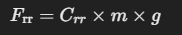

Görseldeki formulu kullanrak yuvarlanma direncini hesaplar


    F_aero = 0.5 * air_density * drag_coefficient * frontal_area * (ego_speed[t] ** 2)


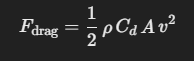

Görseldeki formulu kullanarak aerodinamik kuvveti hesaplar

--------------------------------------------------
--------------------------------------------------

    power_consumed = max(0, (F_rolling + F_aero) * ego_speed[t] / 1000)  # Convert W to kW, ensure non-negative

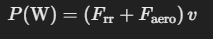

Görseldeki formülü kullanarak harcanan gücü kW cinsinden hesaplar

    energy_consumed[t] = energy_consumed[t-1] + power_consumed * time_step / 3600:

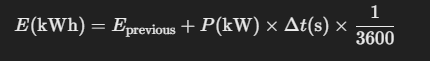

Zamanla tüketilen enerjiyi görseldeki formülü kullanarak hesaplar

--------------------------------------------------
--------------------------------------------------


    if acceleration[t] < 0:  # Braking event
    regen_energy = min(energy_consumed[t],
                       -acceleration[t] * ego_speed[t] * regen_efficiency * time_step / 3600)
    energy_consumed[t] -= regen_energy

-acceleration[t]:
Negatif ivme → pozitif hale getirilir (çünkü -(-a) = a).
Ne kadar sert fren yapıldığı.

🔹 ego_speed[t]:
Fren anındaki aracın hızı. Hızlı giderken fren daha fazla enerji üretir.

🔹 regen_efficiency:
Rejeneratif verimlilik (örneğin %60 = 0.6).
Üretilen enerjinin ne kadarı bataryaya aktarılabilir?

🔹 time_step / 3600:
Hesap saniyelik olduğu için bunu saate çeviriyoruz.
(Çünkü enerji = güç × zaman → zaman birimi saat olmalı ki enerji kWh çıksın)

❗ min(...) Neden Kullanıldı?
Geri kazanılabilecek enerjiyi hesapladık ama şunu unutmamalıyız:

Geri kazanım hiçbir zaman, toplamda harcanan enerjiden fazla olamaz!

Yani:

Eğer frenle 0.5 kWh kazanabilirim ama sadece 0.3 kWh harcamışsam → En fazla 0.3 kWh geri alabilirim.

Bu yüzden min() ile sınır koyuluyor.

--------------------------------------------------
--------------------------------------------------



    battery_soc[t] = max(0, 100 - (energy_consumed[t] / battery_capacity_kWh) * 100)

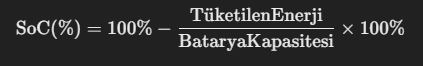

Görseldeki formülü kullanarak Baratya doluluk oranını hesaplar

--------------------------------------------------
--------------------------------------------------

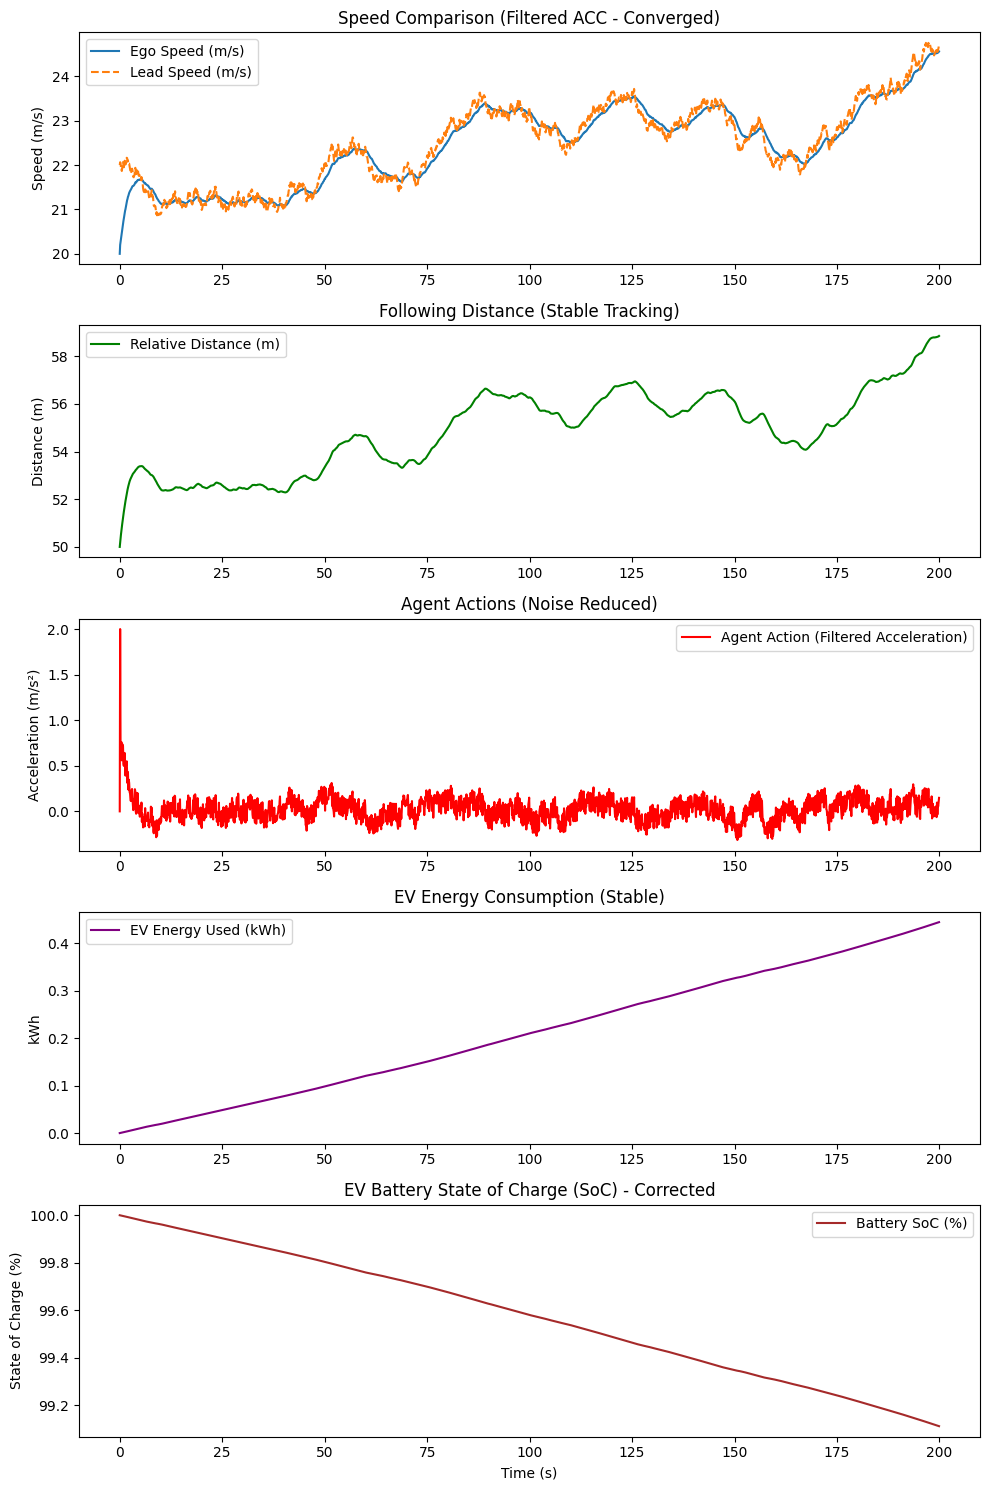

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(10, 15)) # Eni 10 boyu 15 inç olcak şekilde 5 adet alt grafik oluşturur.

axs[0].plot(np.arange(steps) * time_step, ego_speed, label="Ego Speed (m/s)")
axs[0].plot(np.arange(steps) * time_step, lead_speed, label="Lead Speed (m/s)", linestyle="dashed")
axs[0].set_ylabel("Speed (m/s)")
axs[0].set_title("Speed Comparison (Filtered ACC - Converged)")
axs[0].legend()

axs[1].plot(np.arange(steps) * time_step, relative_distance, label="Relative Distance (m)", color="green")
axs[1].set_ylabel("Distance (m)")
axs[1].set_title("Following Distance (Stable Tracking)")
axs[1].legend()

axs[2].plot(np.arange(steps) * time_step, acceleration, label="Agent Action (Filtered Acceleration)", color="red")
axs[2].set_ylabel("Acceleration (m/s²)")
axs[2].set_title("Agent Actions (Noise Reduced)")
axs[2].legend()

axs[3].plot(np.arange(steps) * time_step, energy_consumed, label="EV Energy Used (kWh)", color="purple")
axs[3].set_ylabel("kWh")
axs[3].set_title("EV Energy Consumption (Stable)")
axs[3].legend()

axs[4].plot(np.arange(steps) * time_step, battery_soc, label="Battery SoC (%)", color="brown")
axs[4].set_ylabel("State of Charge (%)")
axs[4].set_xlabel("Time (s)")
axs[4].set_title("EV Battery State of Charge (SoC) - Corrected")
axs[4].legend()

plt.tight_layout()
plt.show()